In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix

import os
import sys
classes_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(classes_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.BaselineHelperFunctions import BaselineHelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes import Tf_shutup
Tf_shutup.Tf_shutup()

from livelossplot import PlotLossesKeras

import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

base_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(base_dir)

In [2]:
num_classes = 2
loadData = LoadData(num_classes = num_classes, isBalanced = True)
shuffle = True
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
data_gen = DataGenerator()

In [3]:
"""
{'model_nr': 5, 'index': 10}
{'batch_size': 32, 'epochs': 35, 'learning_rate': 1e-05, 'optimizer': 'rmsprop'}
{'activation': 'relu', 'dropout_rate': 0.4, 'filters': 21, 'kernel_size': 7, 'l1_r': 0.001, 'l2_r': 0.2, 
'output_layer_activation': 'sigmoid', 'padding': 'same', 'start_neurons': 16}

"""
############ Model picker #############
model_nr = 5

########### Hyperparameters ###########
batch_size = 32
epochs = 100
learning_rate = 0.00001
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0, clipvalue=0.5)
opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
activation = 'relu'
output_layer_activation = 'sigmoid'
dropout_rate = 0.4
filters = 21
kernel_size = 7
l1_r = 0.001
l2_r = 0.2
padding = 'same'
start_neurons = 16

########### Preprocessing ###########
test = False
detrend = False
useScaler = True
use_highpass = True
highpass_freq = 0.2

In [4]:
num_ds, channels, timesteps = data_gen.get_trace_shape_no_cast(train_ds)
input_shape = (batch_size, channels, timesteps)

build_model_args = {'model_nr' : model_nr,
                    'input_shape' : input_shape,
                    'num_classes' : num_classes,
                    'dropout_rate' : dropout_rate,
                    'activation' : activation,
                    'output_layer_activation' : output_layer_activation,
                    'l2_r' : l2_r,
                    'l1_r' : l1_r,
                    'full_regularizer' : True,
                    'start_neurons' : start_neurons,
                    'filters' : filters,
                    'kernel_size' : kernel_size,
                    'padding' : 'same'}
model = Models(**build_model_args).model

model_args = {'loss' : "binary_crossentropy",
              'optimizer' : opt,
              'metrics' : ["accuracy","MSE",
                           tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
model.compile(**model_args)

sigmoid
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 3, 21)               882168    
_________________________________________________________________
batch_normalization (BatchNo (32, 3, 21)               84        
_________________________________________________________________
flatten (Flatten)            (32, 63)                  0         
_________________________________________________________________
dense (Dense)                (32, 2)                   128       
Total params: 882,380
Trainable params: 882,338
Non-trainable params: 42
_________________________________________________________________


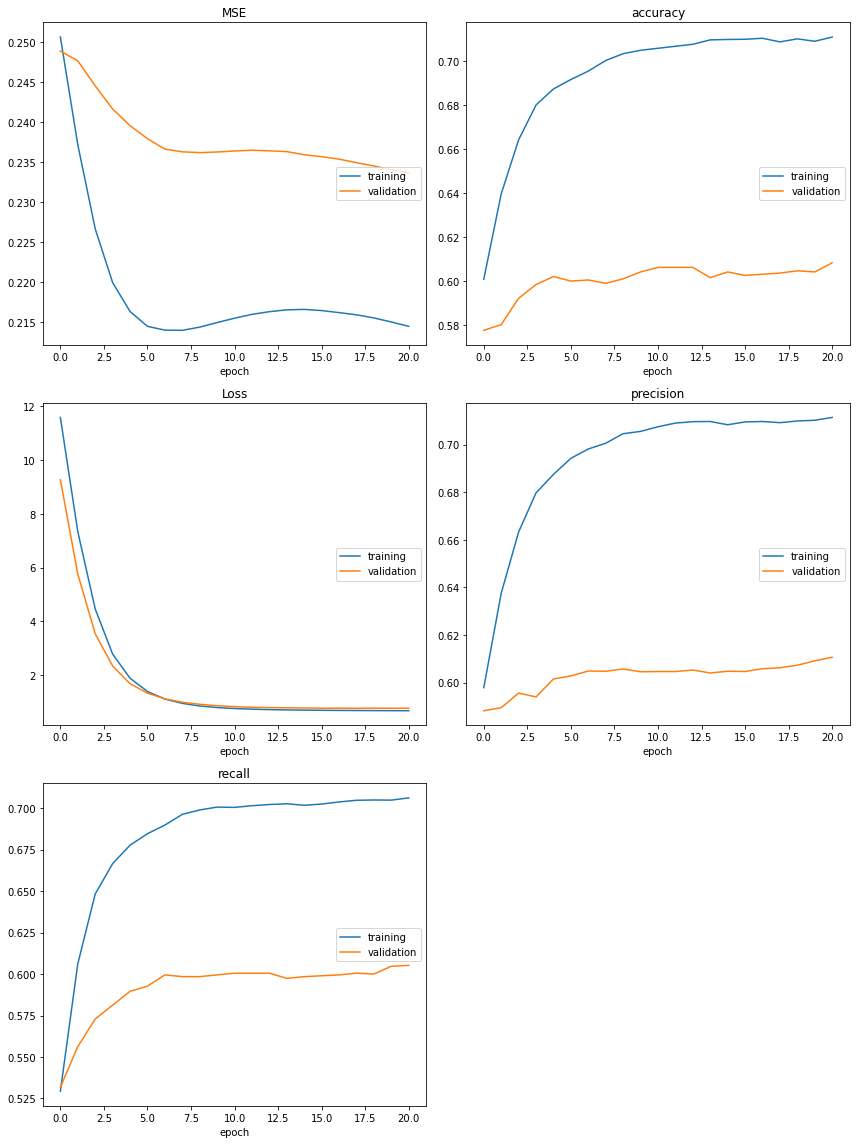

MSE
	training         	 (min:    0.214, max:    0.251, cur:    0.214)
	validation       	 (min:    0.234, max:    0.249, cur:    0.234)
accuracy
	training         	 (min:    0.601, max:    0.711, cur:    0.711)
	validation       	 (min:    0.578, max:    0.608, cur:    0.608)
Loss
	training         	 (min:    0.674, max:   11.587, cur:    0.674)
	validation       	 (min:    0.766, max:    9.270, cur:    0.769)
precision
	training         	 (min:    0.598, max:    0.711, cur:    0.711)
	validation       	 (min:    0.588, max:    0.611, cur:    0.611)
recall
	training         	 (min:    0.529, max:    0.706, cur:    0.706)
	validation       	 (min:    0.532, max:    0.605, cur:    0.605)
343/342 [==============================] - 265s 774ms/step - loss: 0.6744 - accuracy: 0.7110 - MSE: 0.2145 - precision: 0.7114 - recall: 0.7062 - val_loss: 0.7690 - val_accuracy: 0.6083 - val_MSE: 0.2337 - val_precision: 0.6106 - val_recall: 0.6052
Epoch 22/100
 54/342 [===>..........................] - 

KeyboardInterrupt: 

In [5]:
scaler = StandardScalerFitter(train_ds).fit_scaler(test = test, detrend = detrend)

gen_args = {
    'batch_size' : batch_size,
    'test' : test,
    'detrend' : detrend,
    'useScaler' : useScaler,
    'scaler' : scaler,
    'num_classes' : num_classes,
    'use_highpass' : use_highpass,
    'highpass_freq' : highpass_freq
}


train_gen = data_gen.data_generator(train_ds, **gen_args)
val_gen = data_gen.data_generator(val_ds, **gen_args)
test_gen = data_gen.data_generator(test_ds, **gen_args)

custom_callback = CustomCallback(data_gen)

args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size, test),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size, test),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : [PlotLossesKeras()]
}

model_fit = model.fit(train_gen, **args)

In [ ]:
full_logs = custom_callback.full_training_logs

In [ ]:
helper.get_n_points_with_highest_training_loss(train_ds, 100, full_logs)

In [ ]:
def get_n_points_with_highest_training_loss(full_logs, train_ds, n):
    train_ds_dict = {}
    for path, label in train_ds:
        train_ds_dict[path] = {'label' : label,
                               'loss': 0,
                               'average_loss' : 0,
                               'occurances' : 0}
    counter = 0
    for batch in full_logs:
        loss = batch['loss']
        for path_class in batch['batch_samples']:
            train_ds_dict[path_class[0]]['loss'] += loss
            train_ds_dict[path_class[0]]['occurances'] += 1
    
    train_ds_list = []
    for sample in np.array(train_ds[:,0]):
        if train_ds_dict[sample]['occurances'] == 0:
            continue
        train_ds_dict[sample]['average_loss'] = train_ds_dict[sample]['loss'] / train_ds_dict[sample]['occurances']
        train_ds_list.append((sample, train_ds_dict[sample]['label'],train_ds_dict[sample]['average_loss']))
    
    sorted_train_ds_list = sorted(train_ds_list, key=lambda x: x[2], reverse = True)
        
    
    return sorted_train_ds_list[0:n]
        
#get_n_points_with_highest_loss(full_logs, train_ds, 100)   
    

In [ ]:
model.evaluate_generator(generator=test_gen, steps=helper.get_steps_per_epoch(test_ds, batch_size, test))

In [ ]:
print(confusion_matrix(y_true_categorical.argmax(axis=1), predictions[0:1234].argmax(axis=1)))

In [ ]:
helper.plot_confusion_matrix(model, test_gen, test_ds, batch_size, num_classes)

In [ ]:
model.predict_generator(val_gen, 2)

In [ ]:
helper.plot_confusion_matrix(test_ds, batch_size)